# Generatives Trainig mit DeepHull und Max-Distanz loss, generatives und normales Netz trainieren unabhängig voneinander
falls noch kein ICNN Netz exisitiert, kann eins gelernt werden, indem man init auf True setzt

In [1]:
import numpy as np
import torch

from script.Networks import ICNN
from script.Networks import SequentialNN
from torch.utils.data import DataLoader
from script.dataInit import ConvexDataset, Rhombus
from script.trainFunction import train_icnn_adversarial, train_icnn
from script.eval import Plots_for


In [2]:
icnn = ICNN([2, 10, 10, 1])
adversarial = SequentialNN([2, 10, 10, 2])
epochs = 30
batch_size = 10

number_of_adversarial_samples = 1000
number_of_train_samples = 1000
hyper_lambda = 1
x_range = [-1.5, 1.5]
y_range = [-1.5, 1.5]

init = False

In [3]:
true_extremal_points = Rhombus().get_extremal_points()
if init:
    included_space, ambient_space = Rhombus().get_uniform_samples(number_of_train_samples, x_range, y_range) #samples will be split in inside and outside the rhombus
    dataset = ConvexDataset(data=included_space)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataset = ConvexDataset(data= ambient_space)
    ambient_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    random_samples = []
    for i in range(number_of_adversarial_samples): # generate random samples
        x = np.random.default_rng().uniform(low=x_range[0], high=x_range[1])
        y = np.random.default_rng().uniform(low=y_range[0], high=y_range[1])
        random_samples.append([[x, y]])

    value = torch.tensor(random_samples, requires_grad=True, dtype=torch.float64)
    adversarial_set = ConvexDataset(data=value)
    adversarial_loader = DataLoader(adversarial_set, batch_size=batch_size, shuffle=True)

if init:
    torch.save(ambient_space, "../../ambient_space.pt")
    torch.save(included_space, "../../included_space.pt")
    torch.save(value, "../../value.pt")
else:
    icnn.load_state_dict(torch.load("../../icnn.pt"), strict=False)
    ambient_space = torch.load("../../ambient_space.pt").to(torch.float64)
    included_space = torch.load("../../included_space.pt").to(torch.float64)
    value = torch.load("../../value.pt").to(torch.float64)
    dataset = ConvexDataset(data=included_space)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataset = ConvexDataset(data=ambient_space)
    ambient_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    adversarial_set = ConvexDataset(data=value)
    adversarial_loader = DataLoader(adversarial_set, batch_size=batch_size, shuffle=True)

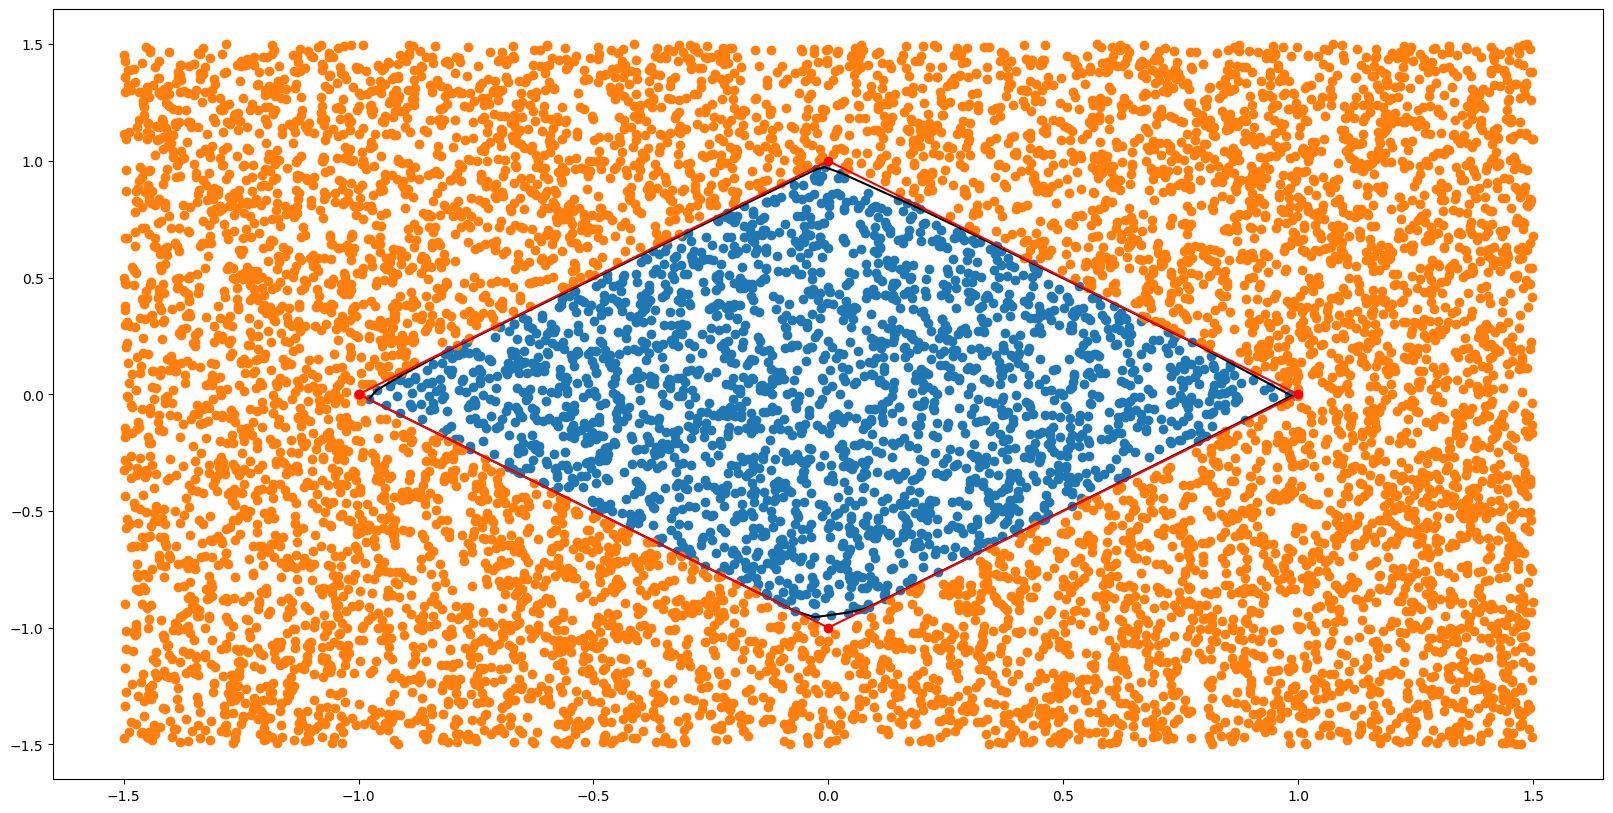

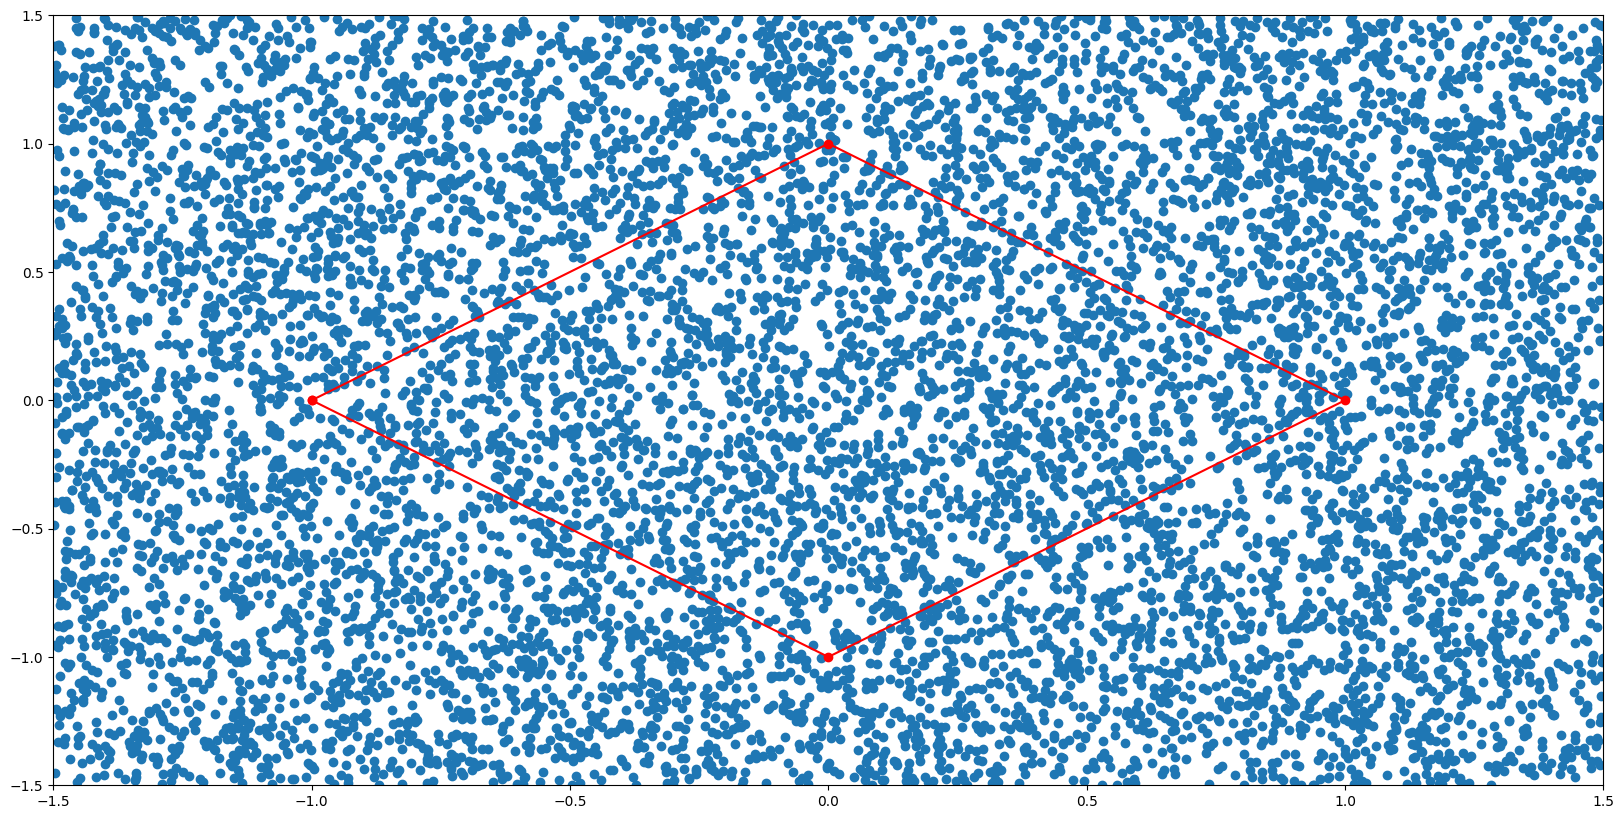

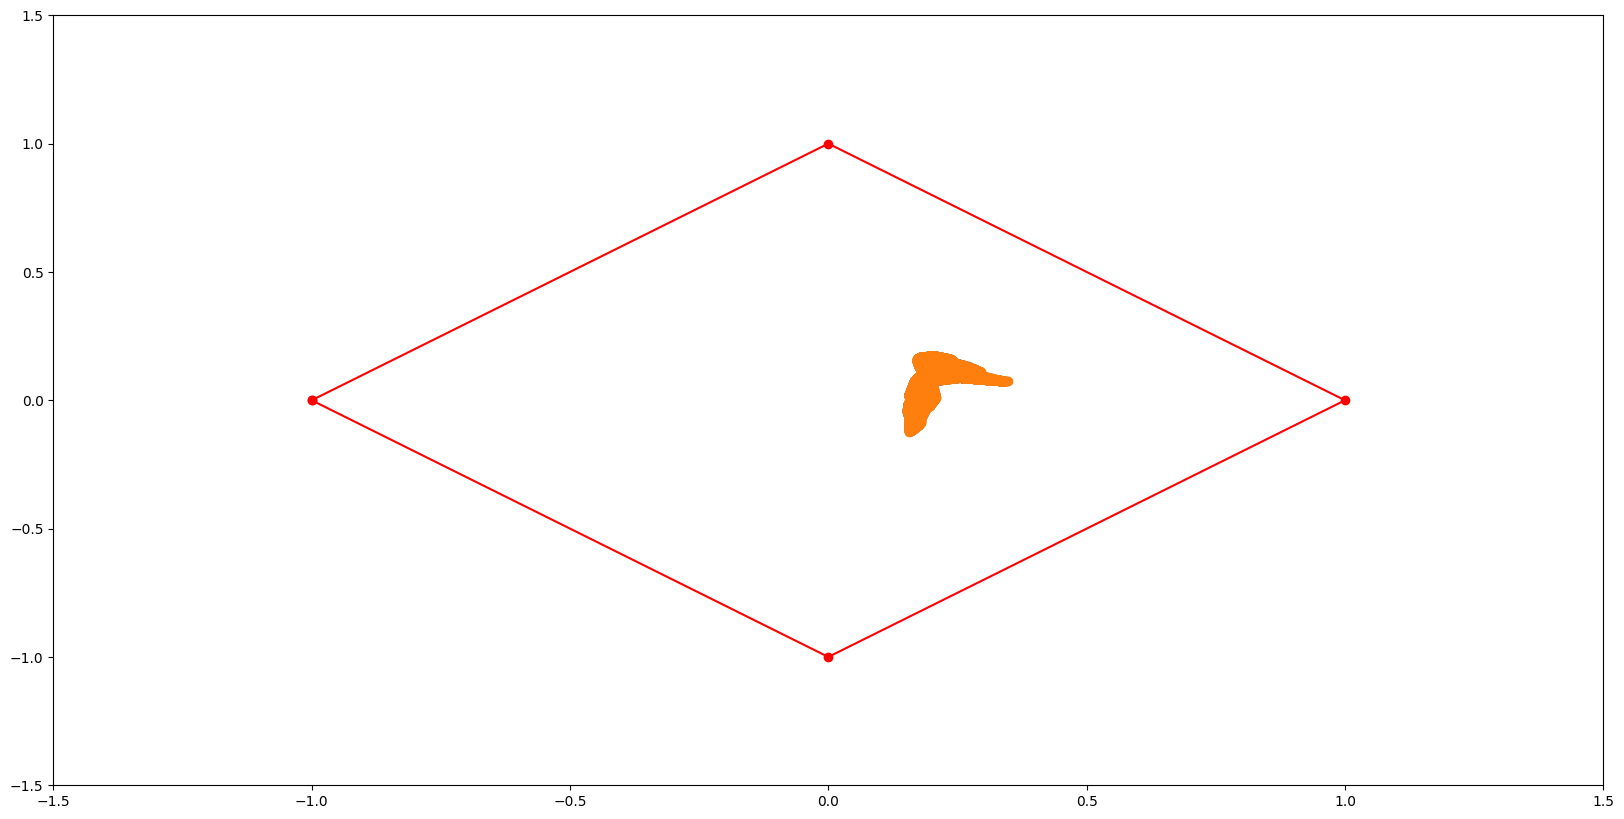

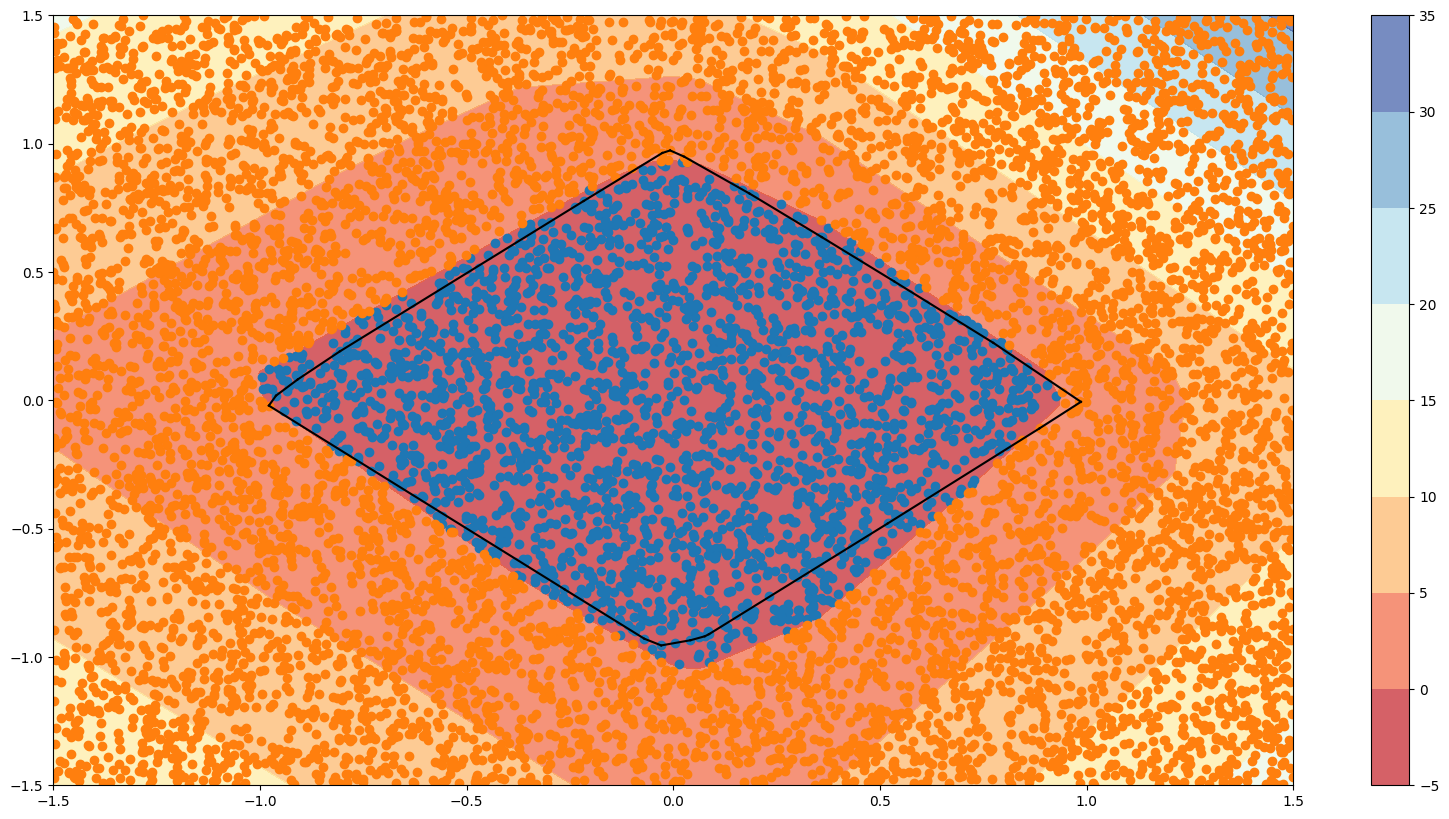

In [4]:
plots = Plots_for(0, icnn, included_space, ambient_space, true_extremal_points, x_range, y_range, adversarial=adversarial, adversarial_values=value)
plots.plt_initial()

plots.plt_adversarial_initial()
plots.plt_adversarial_dotted()

if init:
    history = train_icnn(icnn, train_loader, ambient_loader, epochs=epochs, hyper_lambda=hyper_lambda)
    torch.save(icnn.state_dict(), "../../icnn.pt")
plots.plt_mesh()

=== Epoch: 0===
batch = 0, mean loss = 14.439336806393767, l_pos = 0.20400090097676982, l_neg = 0.0, l_gen = 14.235335905416997
batch = 100, mean loss = 13.043690828657537, l_pos = 0.19355953618200417, l_neg = 0.0, l_gen = 12.850131292475538
batch = 200, mean loss = 11.480717736588273, l_pos = 0.19602195954506957, l_neg = 0.0, l_gen = 11.284695777043213
batch = 221, mean loss = 11.249427176883316, l_pos = 0.19591142368213985, l_neg = 0.0, l_gen = 11.053515753201188
=== Epoch: 1===
batch = 0, mean loss = 9.024574348310532, l_pos = 0.16256349497758366, l_neg = 0.0, l_gen = 8.862010853332949
batch = 100, mean loss = 8.364134173825667, l_pos = 0.19759629050041422, l_neg = 0.0, l_gen = 8.166537883325248
batch = 200, mean loss = 8.00394639819332, l_pos = 0.19614322249553362, l_neg = 0.0, l_gen = 7.807803175697787
batch = 221, mean loss = 7.9733333537751285, l_pos = 0.1959114236821399, l_neg = 0.0, l_gen = 7.777421930092988
=== Epoch: 2===
batch = 0, mean loss = 7.563672280516781, l_pos = 0.2

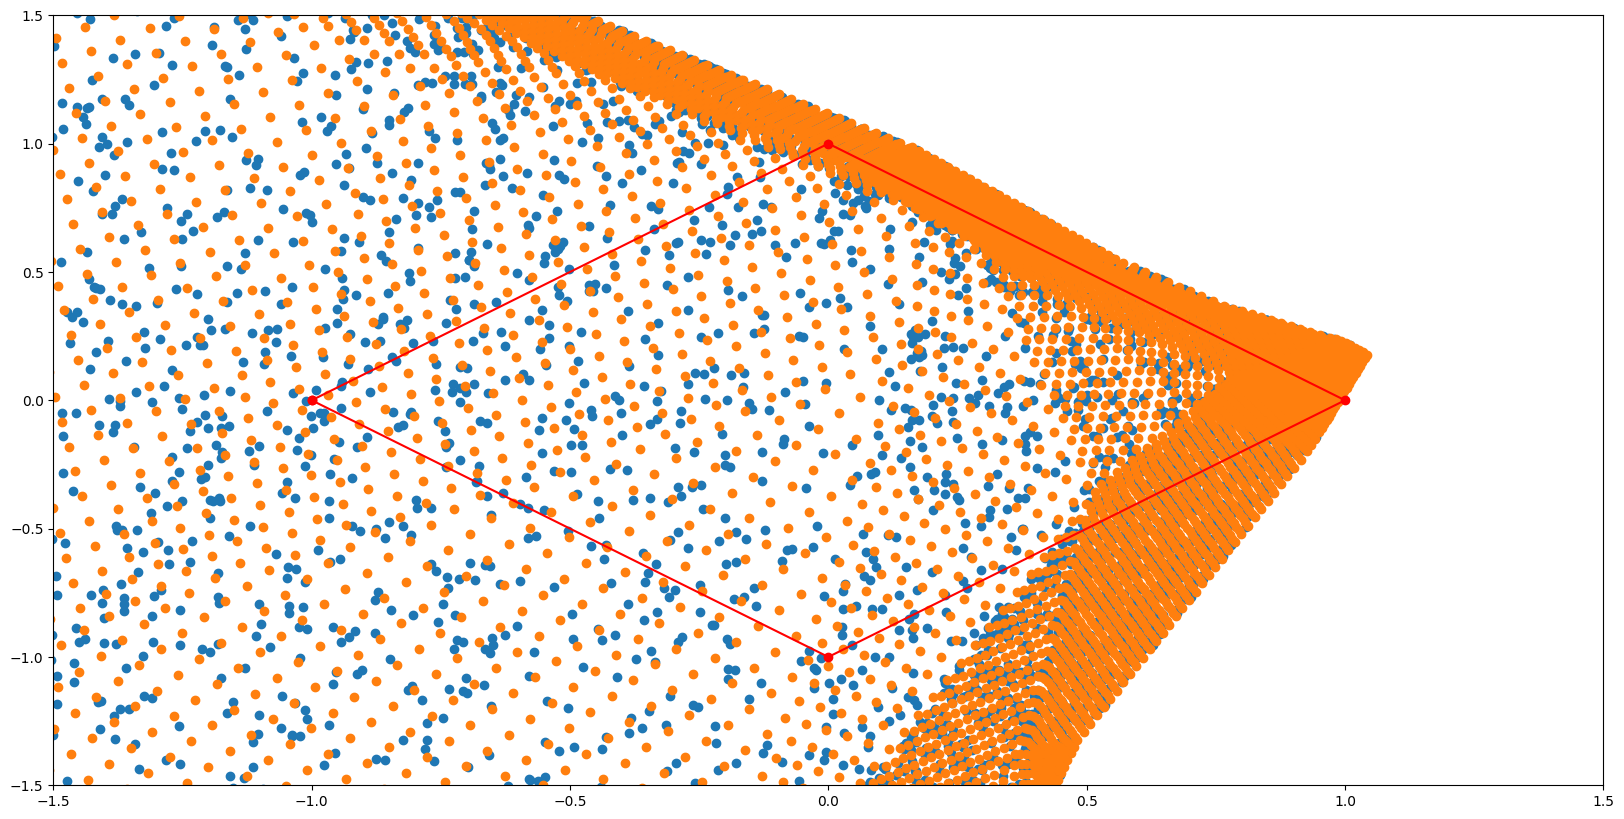

=== Epoch: 0===
batch = 0, mean loss = 7.832938223374838, l_pos = 0.15551506580464403, l_neg = 0.0, l_gen = 7.677423157570194
batch = 100, mean loss = 6.914723200272368, l_pos = 0.19911485520153938, l_neg = 0.0, l_gen = 6.715608345070829
batch = 200, mean loss = 6.9461420084449434, l_pos = 0.19594095737536746, l_neg = 0.0, l_gen = 6.750201051069574
batch = 221, mean loss = 6.955459851831721, l_pos = 0.1959114236821399, l_neg = 0.0, l_gen = 6.759548428149578
=== Epoch: 1===
batch = 0, mean loss = 6.289356384549627, l_pos = 0.22996308936374463, l_neg = 0.0, l_gen = 6.059393295185883
batch = 100, mean loss = 6.887279448906681, l_pos = 0.19648081512829368, l_neg = 0.0, l_gen = 6.690798633778387
batch = 200, mean loss = 6.898714605212676, l_pos = 0.19624245933053958, l_neg = 0.0, l_gen = 6.70247214588213
batch = 221, mean loss = 6.897116647941382, l_pos = 0.19591142368213987, l_neg = 0.0, l_gen = 6.701205224259236
=== Epoch: 2===
batch = 0, mean loss = 8.430755640938886, l_pos = 0.193355897

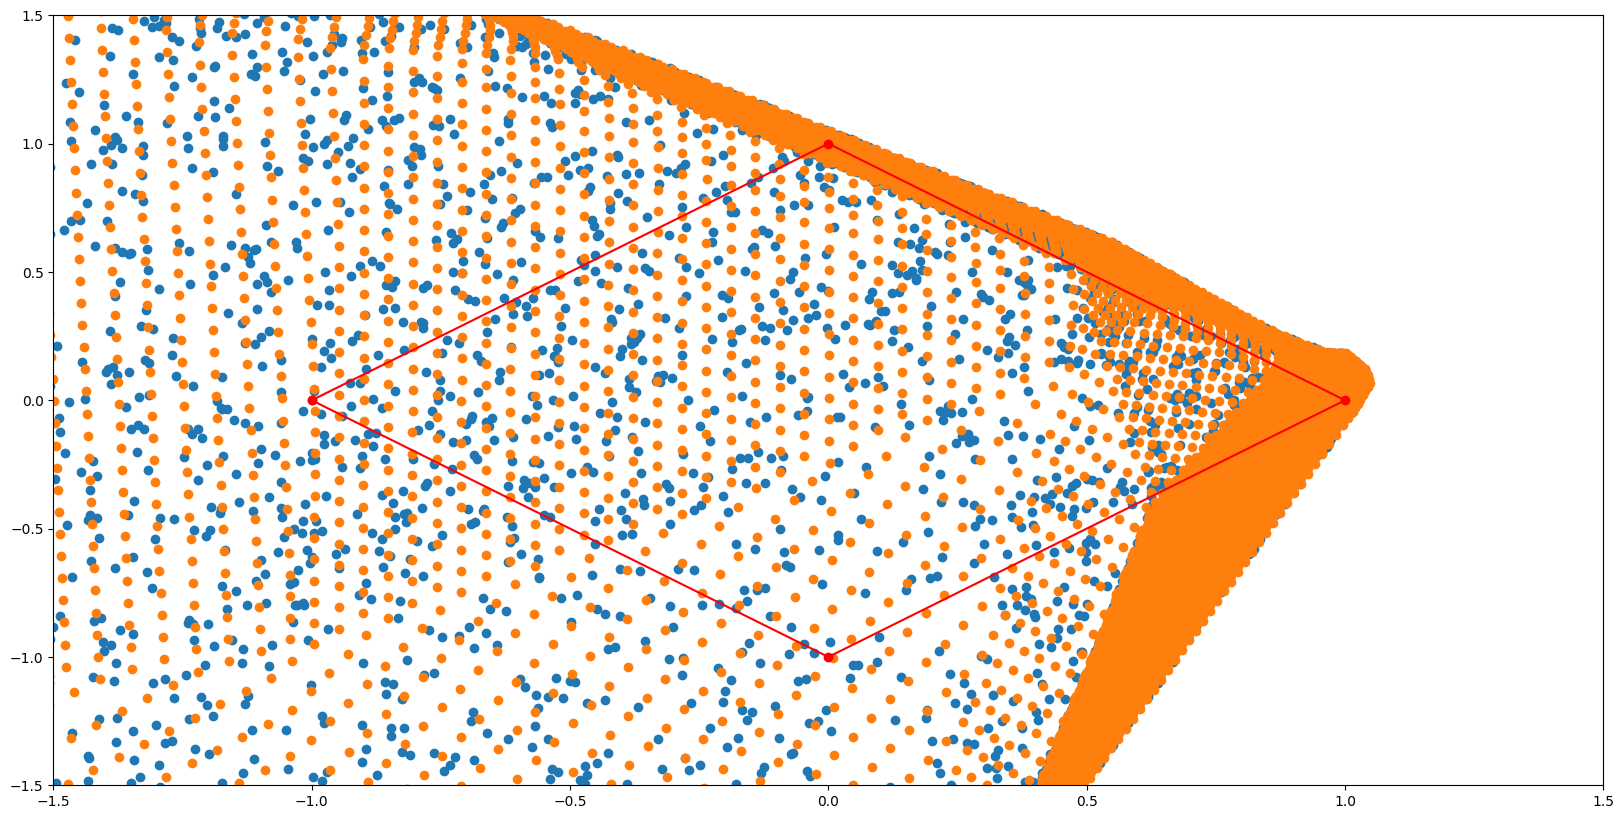

=== Epoch: 0===
batch = 0, mean loss = 6.5566396878369035, l_pos = 0.1485584011899232, l_neg = 0.0, l_gen = 6.40808128664698
batch = 100, mean loss = 6.799438593987024, l_pos = 0.19895466482927907, l_neg = 0.0, l_gen = 6.6004839291577415
batch = 200, mean loss = 6.730918592946776, l_pos = 0.1956629131268458, l_neg = 0.0, l_gen = 6.535255679819923
batch = 221, mean loss = 6.734358003639606, l_pos = 0.1959114236821397, l_neg = 0.0, l_gen = 6.538446579957461
=== Epoch: 1===
batch = 0, mean loss = 5.565617479432368, l_pos = 0.22824225496716594, l_neg = 0.0, l_gen = 5.337375224465202
batch = 100, mean loss = 6.806026586798986, l_pos = 0.19901943836772598, l_neg = 0.0, l_gen = 6.607007148431258
batch = 200, mean loss = 6.775705968786918, l_pos = 0.1968421038960793, l_neg = 0.0, l_gen = 6.578863864890835
batch = 221, mean loss = 6.816167906874529, l_pos = 0.1959114236821398, l_neg = 0.0, l_gen = 6.620256483192388
=== Epoch: 2===
batch = 0, mean loss = 6.4477871577305725, l_pos = 0.21159543615

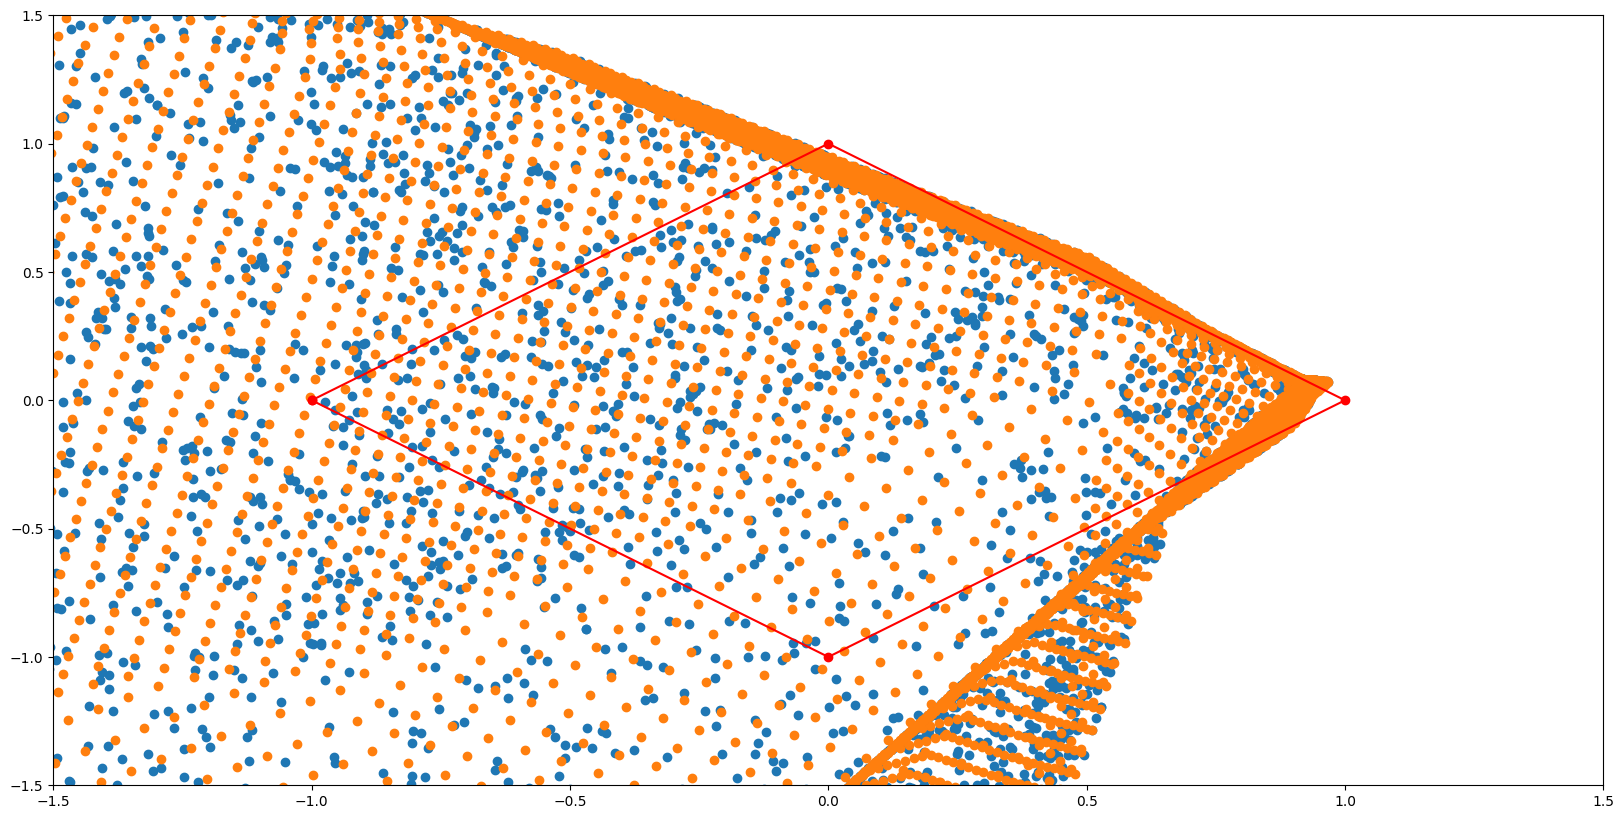

In [5]:
for i in range(int(epochs / 10)):
    history = train_icnn_adversarial(icnn, adversarial, train_loader, adversarial_loader, epochs=10, train_ICNN=False, hyper_lambda=hyper_lambda, use_max_distance=True)
    print("run {}".format(i))
    plots.plt_adversarial_dotted()